In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak
from numpy import random
import time

In [2]:
#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

%config InlineBackend. figure_format = 'retina'

In [14]:
model_theta23 = tf.keras.models.load_model('/work/ML4NO/ML/Regression/models_all/0804_theta23_1.h5')
model_theta23.summary()
model_delta = tf.keras.models.load_model('/work/ML4NO/ML/Regression/furthurTrain/0804_delta1.h5')
model_delta.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 244)               0         
_________________________________________________________________
normalization (Normalization (None, 244)               489       
_________________________________________________________________
dense (Dense)                (None, 1024)              250880    
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

In [15]:
cut_index = np.load('/work/NIO_largerthan1000_index.npy')
data_IO = np.load('/work/NuFit_IO.npz')
data_NO = np.load('/work/NuFit_NO.npz')

In [16]:
input_state = 2
generate = 10

if input_state == 0:
    data_IO_mid = data_IO['ve_dune'][0]
    data_NO_mid = data_NO['ve_dune'][0]
elif input_state == 1:
    data_IO_mid = np.column_stack([data_IO['ve_dune'], data_IO['vu_dune'], data_IO['vebar_dune'], data_IO['vubar_dune']])[0]
    data_NO_mid = np.column_stack([data_NO['ve_dune'], data_NO['vu_dune'], data_NO['vebar_dune'], data_NO['vubar_dune']])[0]
elif input_state == 2:
    data_IO_mid = np.column_stack([data_IO['ve_dune'], data_IO['vu_dune'], data_IO['vebar_dune'], data_IO['vubar_dune'], data_IO['ve_t2hk'], data_IO['vu_t2hk'], data_IO['vebar_t2hk'], data_IO['vubar_t2hk']])[0]
    data_NO_mid = np.column_stack([data_NO['ve_dune'], data_NO['vu_dune'], data_NO['vebar_dune'], data_NO['vubar_dune'], data_NO['ve_t2hk'], data_NO['vu_t2hk'], data_NO['vebar_t2hk'], data_NO['vubar_t2hk']])[0]

data_IO_mid = data_IO_mid
data_NO_mid = data_NO_mid

In [9]:
%%time
N = 1000000
statistics_state = 2

if statistics_state == 0:
    std = 0.01
    data_create_IO = random.normal(data_IO_mid, std*data_IO_mid, size = (N, len(data_IO_mid)))
    data_create_NO = random.normal(data_NO_mid, std*data_NO_mid, size = (N, len(data_IO_mid)))
elif statistics_state == 1:
    data_create_IO = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    data_create_NO = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
elif statistics_state == 2:
    std = 0.01
    data_create_IO = random.normal(data_IO_mid, np.sqrt(data_IO_mid), size = (N, len(data_IO_mid)))
    data_create_NO = random.normal(data_NO_mid, np.sqrt(data_NO_mid), size = (N, len(data_IO_mid)))

CPU times: user 25.6 s, sys: 1.11 s, total: 26.7 s
Wall time: 26.7 s


In [17]:
pre_create_IO_theta23 = model_theta23.predict(data_create_IO)
pre_create_IO_delta = model_delta.predict(data_create_IO)
pre_create_NO_theta23 = model_theta23.predict(data_create_NO)
pre_create_NO_delta = model_delta.predict(data_create_NO)

In [18]:
%%time

IO_or_NO = 1 # 0 for IO and 1 for NO

if IO_or_NO == 0:
    bins_theta23 = np.linspace(min(pre_create_IO_theta23[:,0]), max(pre_create_IO_theta23[:,0]), 100)
    bins_delta = np.linspace(min(pre_create_IO_delta[:,0]), max(pre_create_IO_delta[:,0]), 100)

    likeliregion, xedges, yedges = np.histogram2d(pre_create_IO_theta23[:,0], pre_create_IO_delta[:,0], bins = [bins_theta23,bins_delta])
    max_poi = np.where(likeliregion == likeliregion.max())
    sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]
else:
    bins_theta23 = np.linspace(min(pre_create_NO_theta23[:,0]), max(pre_create_NO_theta23[:,0]), 100)
    bins_delta = np.linspace(min(pre_create_NO_delta[:,0]), max(pre_create_NO_delta[:,0]), 100)

    likeliregion, xedges, yedges = np.histogram2d(pre_create_NO_theta23[:,0], pre_create_NO_delta[:,0], bins = [bins_theta23,bins_delta])
    max_poi = np.where(likeliregion == likeliregion.max())
    sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]   

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/sorted_list.sum() >= 0.68:
        one_sigma_poi = i
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/sorted_list.sum() >= 0.95:
        two_sigma_poi = i
        break

print("one_sigma_poi ", one_sigma_poi)
one_sigma_region = np.where(likeliregion < sorted_list[one_sigma_poi], 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 1, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

print("two_sigma_poi ", two_sigma_poi)
two_sigma_region = np.where(likeliregion < sorted_list[two_sigma_poi], 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 1, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

one_sigma_poi  711
two_sigma_poi  1750
CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.2 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


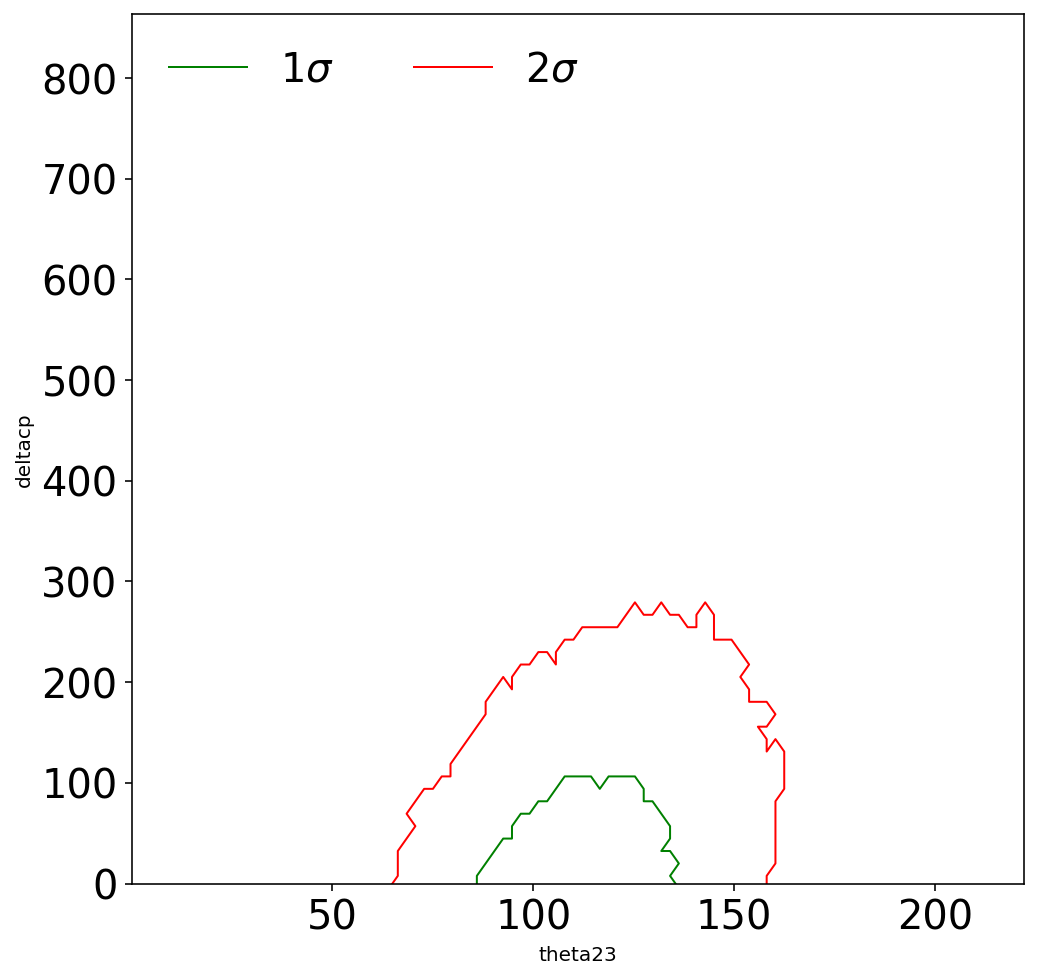

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.45 s


In [19]:
%%time
fig, ax = plt.subplots(1,1, figsize=(8,8))

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
CS_1_sigma = plt.contour(X, Y, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(X, Y, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)

# plt.clabel(CS_1_sigma, inline=True, fontsize=10)

CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")

# plt.xlim((-0.8,0.8))
# plt.xlim((0.,0.09))
# plt.xlim((49.277,49.279))
# plt.ylim((289.70,289.75))

plt.ylim((min(pre_create_IO_delta[:,0]), max(pre_create_IO_delta[:,0])))
plt.xlim((min(pre_create_IO_theta23[:,0]), max(pre_create_IO_theta23[:,0])))
plt.ylim((0, max(pre_create_IO_delta[:,0])))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.xlabel("cos($\\beta$ - $\\alpha$)", fontsize=25, horizontalalignment='right',x=1)
# plt.ylabel('$m_{12}^2$ [$\mathrm{GeV}^2$]', fontsize=25,horizontalalignment='right',y=1)
plt.legend(loc="upper left", ncol=2, fontsize=20, markerscale=2., scatterpoints=1,
           edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
# plt.ticklabel_format(style='plain')
# plt.grid()
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.xlabel('theta23')
plt.ylabel('deltacp')
if IO_or_NO == 0:
    if statistics_state == 0: plt.title('0804 IO gaussian, std = {}'.format(std))
    if statistics_state == 1: plt.title('0804 IO poisson')
else: 
    if statistics_state == 0: plt.title('0804 NO gaussian, std = {}'.format(std))
    if statistics_state == 1: plt.title('0804 NO poisson')
plt.show()